# SLT-CE-2: Sampling

In this coding exercise we will test various Markov Chain Monte Carlo (MCMC) sampling procedures [1] introduced during the tutorial session. We will first tackle the image reconstruction problem followed by the traveling salesman problem.

## Task (image reconstruction problem)


Given a noisy [binary image](https://en.wikipedia.org/wiki/Binary_image) one needs to recover the original through denoising. To do so we will use the prototypical [Ising model](https://en.wikipedia.org/wiki/Ising_model) from physics as explained in section 8.3.3 of [2]. An undirected graphical model is designed to model (i) the adherence of the reconstruction to the observed noisy image and (ii) the correlation between neighboring pixels. We are interested in recovering a single image, the most likely one, with respect to the underlying distribution i.e. we do MAP inference to discover the peak of the posterior distribution $p(image\_reconstruction | noisy\_observation)$.


### References 
[0] [SLT Tutorial 3 on Sampling](https://ml2.inf.ethz.ch/courses/slt/tutorials/tutorial03-sampling.pdf)

[1] http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf

[2] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

## Model

Given a noisy, binary image $y=(y_1,\dots,y_n)$ where $y_i\in\{\pm1\}$ is the value of the i-th pixel, the Ising model tries to find a denoised image $x=(x_1,\dots,x_n)$ by minimizing the following energy function:

$$E(x|y) = - \frac{\beta}{2} \sum_{i} \frac{x_i}{\lvert N_i\rvert}\sum_{j \in N_i} x_j - \mu \sum_{i} x_i y_i$$

where $N_i$ is the set of neighbors of pixel $i$. For a 2D image the pixel neighbourhood $N_i$ usually involves $\lvert N_i\rvert=$ 4 or 8 surrounding pixels. In this exercise we consider only the 4 pixel neigbourhood (up, down, left and right pixels). The undirected probabilistic graphical model from where the energy function $E(x|y)$ is derived is explained in more detail in [2].

 <h2> Setup </h2>

We start by importing necessary python packages.

In [1]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time

from skimage.transform import resize
from scipy.signal import fftconvolve
from sklearn.metrics import hamming_loss

from scipy.optimize import minimize_scalar
from multiprocessing import cpu_count
from pathos.multiprocessing import ProcessingPool as Pool

import warnings
warnings.filterwarnings('ignore')

In [2]:
def flower(size=None, p=0.3):
    """Load image data for denoising
    
    Args:
        size (tuple): image size, default (300,300)
        p (float): noise fraction in [0,1]
        
    Returns:
        noisy: noisy image
        img: ground truth image
    """
    img = mpimg.imread("flower.png") # Load image
    
    # Binarize image
    img[img > 0.5] = 1
    img[img <= 0.5] = -1
    
    # Resize image 
    if size is not None:
        img = resize(img, size)
        img[img > 0] = 1
        img[img <= 0] = -1
    
    np.random.seed(13)

    flip = np.random.choice([-1, 1], size=img.shape, p=[p, 1-p])

    noisy = flip * img
    
    return noisy, img

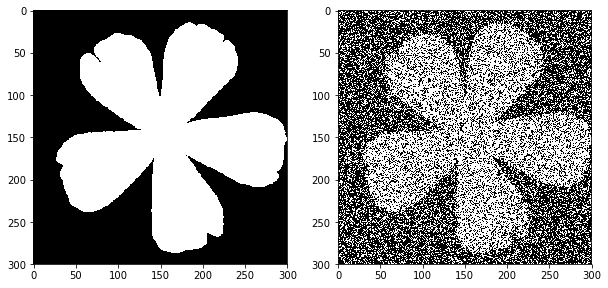

In [3]:
noisy, img = flower()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(noisy,cmap='gray')
plt.show()


<h2 style="background-color:#ffffff;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>
<p style="background-color:#ffffff;">
Shortly describe the following sampling procedures, and provide the key formulas. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p> 




- **Metropolis-Hastings**: 
1. Define a parameterized family of conditional proposal distributions $\{q(·|c) |c \in C\}$ such that $G_q$ is connected and every vertex in $G_q$ has an edge to itself.
2. Define, for $c,c' \in C$ , the accepting probability: $$A(c,c'):= \min{ \{1,\dfrac{q(c|c')p(c')}{q(c'|c)p(c)} }\}$$
3. The transition distribution is then: 
$$  
\pi(c'|c) := \begin{cases} 
      q(c'|c)A(c,c') & \text{if} \; c \neq c' \\
      1- \sum_{c' \neq c}q(c'|c)A(c,c') & \text{otherwise}  
   \end{cases}
$$

- **Metropolis**: In the particular case when $q(c|c')=q(c'|c) \; \forall c,c' \in C$, the Metropolis-Hastings is called Metropolis algorithm. The acceptance probability becomes: $$A(c,c'):= \min{ \{1,\dfrac{p(c')}{p(c)} }\}$$

- **Simulated Annealing**: 
Simulated annealing overcomes the tradeoff between high/low temperature with a natural solution: start at ahigh temperature and then alternate between MCMC sampling and decreasing the temperature. This technique offers two advantages.  First, the gradual temperature decrease allows the hunter to escape bad local minima, while searching for the cost function’s global minima. Second,  the  sampling  nature  of  simulated  annealing  gives  usnot one but many solutions that are in the “neighborhood” of the empirical risk minimizer.

<p style="background-color:#ffffff;">
    Implement the energy function introduced in the model section of the notebook.<br>
    <b> (!)</b> Deliberately implement a naive solution, which explicitly performs (nested) loops to compute the sums. 
    </p>

In [4]:
def energy(img_noisy_observation, img_estimate, beta=2.5, mu=1):
    """Compute the energy for given estimate 'img_estimate' which
    is our vector x in the original model, with respect to the 
    observation 'img_noisy_observation', which corresponds to the vector y in the model.

    Args:
        img_estimate (np.ndarray): estimated image matrix
        img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
        energy (float): energy of the estimate given observation
    """
    height = img_estimate.shape[0]
    width = img_estimate.shape[1]
    
    E = 0
    x_y_sum = 0
    x_x_sum = 0
    for i in range(height):
        for j in range(width):
            x_y_sum +=  img_estimate[i][j]* img_noisy_observation[i][j]
            neighbors = 0
            if i+1 < height:
                neighbors += img_estimate[i+1][j]
            if i-1 >= 0:
                neighbors += img_estimate[i-1][j]
            if j+1 < width:
                neighbors += img_estimate[i][j+1]
            if j-1 >= 0:
                neighbors += img_estimate[i][j-1]
            
            x_x_sum +=  img_estimate[i][j] * neighbors
    E = - beta/8* x_x_sum - mu*x_y_sum
    return E 

<p style="background-color:#ffffff;">Make sure to get the correct result:</p>

In [5]:
assert np.isclose(energy(*flower()), -145700.75)

<p style="background-color:#ffffff;">Implement metropolis sampling.<br>
<b>(!)</b> Deliberately implement a naive solution, which loops over each pixel, attempts a flip, measures the energy before and after, and then decides whether to accept the flip, or not. Use the naive energy function from before.
</p>

In [8]:
def metropolis(img_noisy_observation, epochs, T=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using energy.

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of the simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    energies = []
    for e in range(epochs):
        
        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for cnt, idx in enumerate(np.random.permutation(n_pixels)):
            
            print("Finished {:6.2f}% of epoch {}".format(cnt/n_pixels * 100, e+1), end="\r")
            i = idx//width
            j = idx%width
            e_1 = energy(noisy_img,estimate)
            estimate[i][j] = - estimate[i][j]
            e_2 = energy(noisy_img,estimate)
            p = min(1,np.exp(1/T * (e_1-e_2)))
            flip = np.random.binomial(1,p,1)
            if flip == 0:
                estimate[i][j] = - estimate[i][j]
    
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#ffffff;">
    Evaluate your implemented metropolis algorithm, using the provided evaluation function.<br>
    The energy should decrease over epochs. The reconstructed image should be a denoised version of the noisy image.
    </p>

In [6]:
def evaluate_ising(method, img_noisy_observation, img_original, epochs=1, T=1, surpress=False):
    """ Given a sampling method, we will run the sampling procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
        method (function pointer): sampling method
        img_noisy_observation (np.ndarray): noisy image matrix
        img_original (np.ndarray): original image matrix
        epochs (int): number of epochs to run the sampling, one epoch means going through all pixels once.
        T (float): The positive temperature of the simulation
    """

    start_time = time.time()
    img_estimate, energies = method(img_noisy_observation, epochs, T)
    execution_time = time.time() - start_time

    if not surpress:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

        ax1.plot(energies, marker="x")
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('energy')

        ax2.imshow(img_estimate, cmap='gray')
        ax2.set_title('Reconstruction')
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

        ax3.imshow(img_noisy_observation, cmap='gray')
        ax3.set_title('Input')
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)

        plt.suptitle("{} updates per second".format(int(img_original.size*epochs/execution_time)))

        plt.show()
    
    return energies[-1], hamming_loss(y_pred=img_estimate.flatten(), y_true=img_original.flatten())

<p style="background-color:#ffffff;">
    The naive implementation is incredibly slow, so we use a downsampled image for evaluation.
</p>

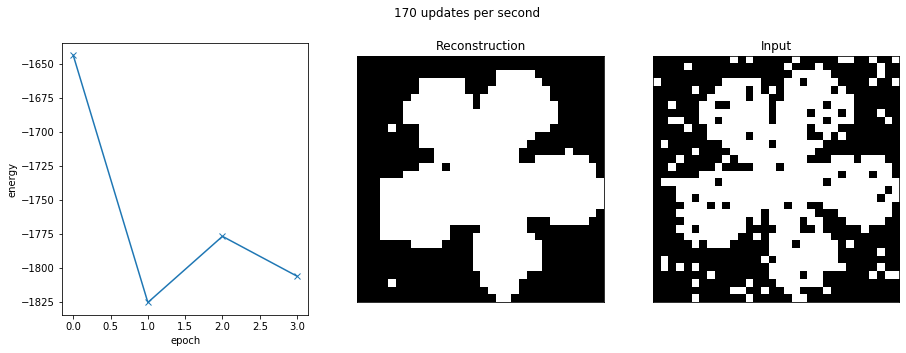

In [10]:
E_metro = evaluate_ising(metropolis, *flower(size=(32,32), p=0.1), epochs=3)

<h2 style="background-color:#ffffff;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#ffffff;">
We are now considering a different problem. We want to solve the <a href="https://en.wikipedia.org/wiki/Travelling_salesman_problem">traveling salesman problem</a> for N=532 major cities in the USA.
</p>

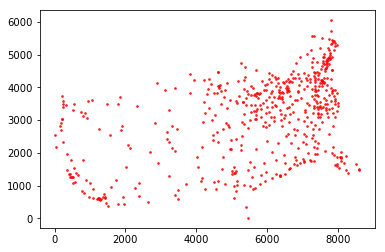

In [11]:
coordinates = pd.read_csv("cities.csv", names=['x', 'y'], sep=';', index_col=False)
coordinates = np.asarray(coordinates)  # Nx2 array containing the coordiantes of the cities
plt.scatter(coordinates[:,0], coordinates[:,1], s=3, c="r", alpha=0.75)
plt.show()

<p style="background-color:#ffffff;">
Implement the distance function for the TSP:
</p>

In [12]:
def distance(coordinates, route=None):
    """Calculate travel distance.
    
    If no route is given, assumes that coordinates are travelled in order,
    starting at the first entry, and connecting the last entry again with the first.
    
    Args:
        coordinates (np.ndarray): route coordinates (assume in units of meters)
        route: permutation of coordinate order
        
    Returns:
        float: traveled distance in units of kilometers
    """
     
    if route is not None:
        coordinates = coordinates[route]
    x = np.roll(coordinates,-1,axis=0)
    return np.sum(np.linalg.norm(coordinates-x,axis=1))/1000


<p style="background-color:#ffffff;">
Make sure it returns the correct value:
</p>

In [13]:
assert np.isclose(distance(coordinates), 978.3514183630234)

In [14]:
def evaluate_tsp(method, coordinates, epochs=1):
    """Evaluate sampling method on coordinates
    
    Args:
        method (function pointer): sampling method
        coordinates (np.ndarray): city coordinates, shape Nx2
        epochs (int): number of epochs to run the sampling
    """
    np.random.seed(7)
    N = coordinates.shape[0]
    route = np.random.permutation(N)
 
    start_time = time.time()
    route, distances = method(coordinates, route, epochs)
    execution_time = time.time() - start_time

    if not (np.sort(route) == range(N)).all():
        raise ValueError("Returned route is not valid!")

    x, y = coordinates[route, 0], coordinates[route, 1]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.plot(distances, marker="o", markersize=3)
    plt.plot([0, len(distances)], [27686/1000,27686/1000], c="green") # best known solution
    plt.grid(axis="y")
    
    plt.subplot(122, xticks=[], yticks=[])
    plt.plot(x, y, alpha=0.5, c="blue", marker="o", markerfacecolor="red", markersize=3, linewidth=1)
    plt.plot([x[0], x[-1]], [y[0], y[-1]], alpha=0.5, c="blue", linewidth=1)
    
    plt.show()

<p style="background-color:#ffffff;">
First, solve the traveling salesman problem with metropolis, and then with simulated annealing. <br>
We consider all permutations of $(1,\dots,N)$ as the solution space, so one route corresponds to one permutation. <br>
As proposals use transpositions instead of pixel flips. <br>
More precisely, pick a random index $i$, and exchange it with its successor, i.e. $(x_1,\dots,x_i, x_{i+1},\dots,x_N) \rightarrow (x_1,\dots,x_{i+1}, x_{i},\dots,x_N)$.<br>
    Keep in mind, that TSP goes in a cycle, so the successor of N is 1.
</p>

In [15]:
def metropolis_tsp(coordinates, route=None, epochs=1, T=1):
    """Metropolis for TSP

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        epochs (int): number of loops through all cities.
        T (float): Temperature of simulation

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))
    for e in range(epochs):
        
        for idx in np.random.permutation(N):
            proposal_route = route.copy()
            if idx+1 < len(route):
                tmp = proposal_route[idx+1]
                proposal_route[idx+1] = proposal_route[idx]
                proposal_route[idx] = tmp
            else:
                tmp = proposal_route[-1]
                proposal_route[-1] = proposal_route[0]
                proposal_route[0] = tmp
            d_1 = distance(coordinates,route)
            d_2 = distance(coordinates,proposal_route)
            p = min(1,np.exp(1/T * (d_1-d_2)))
            flip = np.random.binomial(1,p,1)
            if flip == 1:
                route = proposal_route
        
        distances.append(distance(coordinates, route))

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#ffffff;">
Evaluate your metropolis algorithm for the traveling salesman problem.
</p>

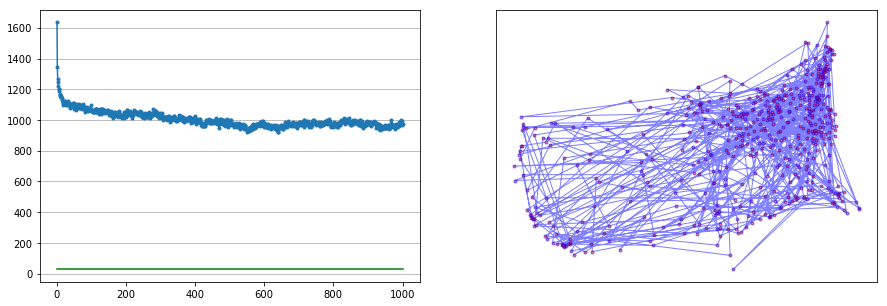

CPU times: user 46.8 s, sys: 133 ms, total: 47 s
Wall time: 47 s


In [16]:
evaluate_tsp(metropolis_tsp, coordinates, epochs=1000)

In [17]:
def simulated_annealing(coordinates, route=None, epochs=1, T=20.0, eta=0.995):
    """Simulated Annealing for TSP

    T(n) = T * eta**n


    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        route (array): inital route
        epochs (int): number of loops through all cities.
        T (float): Initial temperature
        eta (float): Exponential cooling rate

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))

    for e in range(epochs):
        if T == 0:
            break
        for idx in np.random.permutation(N):
            proposal_route = route.copy()
            if idx+1 < len(route):
                tmp = proposal_route[idx+1]
                proposal_route[idx+1] = proposal_route[idx]
                proposal_route[idx] = tmp
            else:
                tmp = proposal_route[-1]
                proposal_route[-1] = proposal_route[0]
                proposal_route[0] = tmp
            d_1 = distance(coordinates,route)
            d_2 = distance(coordinates,proposal_route)
            p = min(1,np.exp(1/T * (d_1-d_2)))
            flip = np.random.binomial(1,p,1)
            if flip == 1:
                route = proposal_route
        T  *= eta
                
        distances.append(distance(coordinates, route))

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#ffffff;">
Evaluate your simulated annealing algorithm for the traveling salesman problem.
</p>

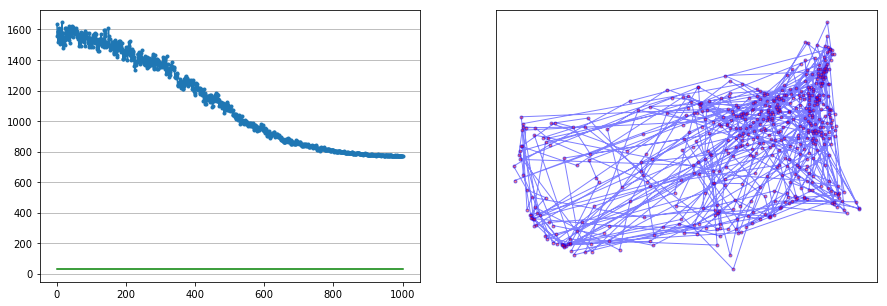

In [18]:
evaluate_tsp(simulated_annealing, coordinates, epochs=1000)

<h2 style="background-color:#ffffff;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#ffffff;">
    Optimize the calculation of the naive metropolis for the Ising problem by taking into account that the energy change caused by a single flip depends only on the affected pixel's value, and its neighborhood.<br>
    More precisely, implement the function local_energy_change, and use it in the method local_metropolis.
</p>

In [19]:
def local_energy_change(noisy, estimate, i, j, beta, mu):
    """
    
    Local energy difference between unflipped and flipped pixel i,j 
    
    Args:
        noisy: noisy reference image
        estimate: current denoising estimate
        i,j: Position of pixel
    
    Returns:
        float: local energy difference when pixel i,j is flipped 
    """
    height = estimate.shape[0]
    width = estimate.shape[1]

    neighbors = 0
    if i+1 < height:
        neighbors += estimate[i+1][j]
    if i-1 >= 0:
        neighbors += estimate[i-1][j]
    if j+1 < width:
        neighbors += estimate[i][j+1]
    if j-1 >= 0:
        neighbors += estimate[i][j-1]
    
    d1 = -beta/2* (estimate[i][j]*neighbors)
    d2 = -2*mu*(estimate[i][j] * noisy[i][j])
    dE = d1+d2

    return dE

def local_metropolis(img_noisy_observation, epochs, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using local_energy_change 

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    energies = []
    for e in range(epochs):
        
        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for cnt, pix in enumerate(np.random.permutation(n_pixels)):
            i = pix//width
            j = pix%width
            dE = local_energy_change(noisy_img,estimate,i,j,beta,mu)
            p = min(1,np.exp(1/T * dE))
            flip = np.random.binomial(1,p,1)
            if flip == 1:
                estimate[i][j] = - estimate[i][j]
        
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#ffffff;">
    We run two evaluations, one for the small image, and one on the full image.
    </p>

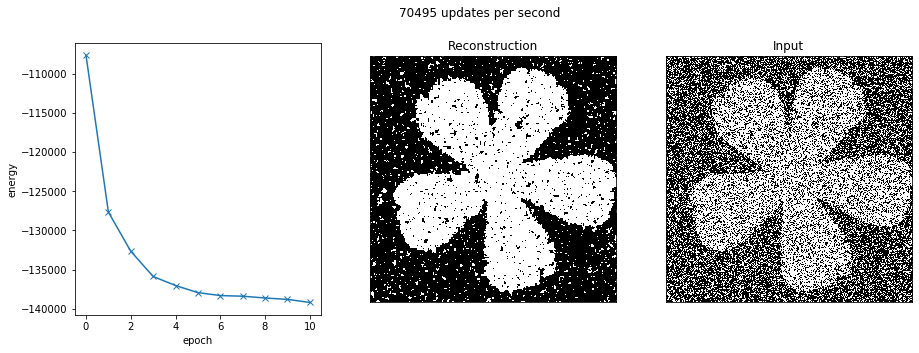

(-139201.0, 0.07365555555555556)

In [20]:
E_local = evaluate_ising(local_metropolis, *flower(size=(32,32), p=0.1), epochs=3, surpress=True);
evaluate_ising(local_metropolis, *flower(), epochs=10)

<p style="background-color:#ffffff;">
    Make sure, metropolis and local_metropolis are equivalent:
    </p>

In [21]:
assert E_metro == E_local

<h2 style="background-color:#ffffff;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#ffffff;">
    We can speed up metropolis for the Ising model even further by using vectorized operations, i.e. using operations on arrays instead of looping over pixels.<br>
    Implement checkerboard_metropolis, which alternatingly updates two independent sub-grids at once.
    Your final code must have only one for-loop, namely over epochs (not counting the loop over the two grids). Use fftconvolve to compute the neighborhood term of the energy difference.
    </p>

In [7]:
def checkerboard_energy_change(noisy_img, estimate, grid, beta, mu):
    """Compute energy change when flipping pixels in grid
    
    When using the 4-neighborhood, a 2D image can be separated in two
    independent grids, hence the name checkerboard.
    All the pixels in one grid can be updated simultaneously, because they
    are independent. Using this property, we can improve computational
    efficiency by using vectorized operations instead of loops.
    
    Args:
        noisy_img: Noisy reference image
        estimate: Current image reconstruction
        grid: Flat array or list of grid indices.
    
    Returns:
        numpy.array: Energy change for each pixel in grid,
            same size as grid.
    
    """
    kernel = np.array([[0, 1, 0],[1, 0, 1],[0, 1, 0]])
    neighbor = fftconvolve(estimate,kernel,mode='same')
    d1 = -2 * mu * estimate * noisy_img * grid 
    d2 = -beta/2 * estimate * neighbor * grid
    dE = d1 + d2
    return dE

In [8]:
def checkerboard_metropolis(img_noisy_observation, epochs=1, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    Alternatingly update two independent grids

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(27) # Always set the random seed to a lucky number

    n_pixels = img_noisy_observation.size
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    grid_one = np.indices(noisy_img.shape).sum(axis=0) % 2
    grid_two = np.ones(noisy_img.shape) - grid_one
    grids = [grid_one,grid_two]

    energies = []
    for e in range(epochs):

        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for grid in grids:
            dE = checkerboard_energy_change(noisy_img, estimate, grid, beta, mu)
            p = np.clip(np.exp(1/T * dE) * grid,0,1)
            p = np.random.binomial(1,p)
            p[p == 1] = -1
            p[p == 0] = 1
            estimate = estimate * p 
                
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#ffffff;">
    Run the checkerboard_metropolis:
    </p>

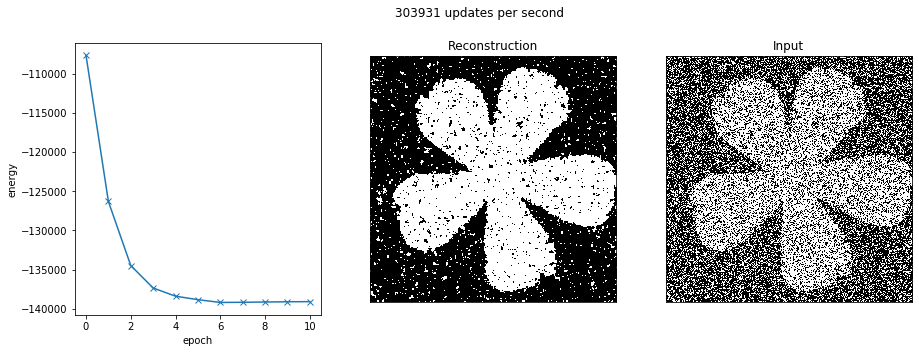

(-139106.75, 0.0688)

In [9]:
evaluate_ising(checkerboard_metropolis, *flower(), epochs=10)

<p style="background-color:#ffffff;">
    Run the experiment below, and explain the observed behavior!
    </p>

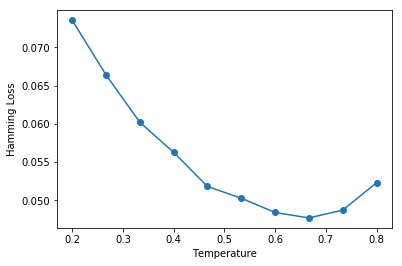

In [295]:
Trange = np.linspace(0.2,0.8,10)
loss = [evaluate_ising(checkerboard_metropolis, *flower(), epochs=10, T=T, surpress=True)[1]
         for T in np.linspace(0.2,0.8,10)]

plt.plot(Trange, loss, marker="o")
plt.ylabel("Hamming Loss")
plt.xlabel("Temperature")
plt.show()

Write your explanation here

The plot resembles a classic bias/variance tradeoff diagram where the optimal value for the temperature $t^*$ is contained in the interval $[0.6,0.7]$. On the left of $t^*$ we can observe the "overfitting zone": the temperature is too low and the posterior distribution will be too "peaked" around one solution in $\mathcal{C}$ (high variance and low generalization). On the right of $t^*$ we can observe the "under-fitting zone": the temperature is too high and the posterior distribution will be too flat over the solution space (high bias).


<p style="background-color:#ffffff;">
Run the experiment below, and explain the observed behavior!
</p>

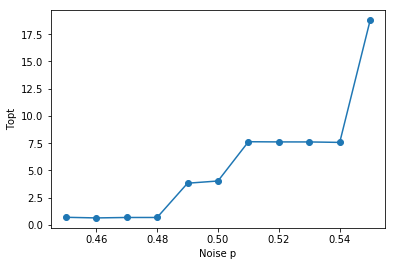

In [15]:
def find_Topt(p):
    f = lambda T: evaluate_ising(checkerboard_metropolis, *flower(p=p), epochs=10, T=T, surpress=True)[1]
    result = minimize_scalar(f, options={"xatol": 0.001}, bounds=(0, 20), method="bounded")
    return result.x

prange = np.arange(0.45, 0.55, 0.01)
with Pool(cpu_count()) as pool:
    Topt = pool.map(find_Topt, prange)
    
plt.plot(prange, Topt, marker="o")
plt.ylabel("Topt")
plt.xlabel("Noise p")
plt.show()

Write your explanation here

The plot shows a positive correlation between noise and optimal temperature: as the noise increases the optimal temperature follows. This can be explained by the fact that the more noise we have the "flatter" and closer to a uniform distribution the posterior gibbs distribution should be. Indeed, if we consider the limit $p \to 1$ the posterior distribution should be uniform over the solution space $\mathcal{C}$ because we have no information to find the original image. As $p$ decreases, the amount of information we have at our disposal to reconstruct the image increases and we expect our posterior gibbs to be more "peaked" ($\implies$ decreasing temperature $T$).

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#ffffff;">
Implement a more sophisticated proposal distribution, which is more appropriate for TSP than simple transpositions. <br>
Consider your idea successful, if the travel distance goes at least below 300.<br>
Moreover, make sure that your algorithm fullfills detailed balanced by using the Metropolis-Hastings acceptance probability:<br>
    
</p>

$p_{accept}=\min(\frac{p(x\rightarrow y)}{p(y\rightarrow x)}e^{-\frac{\Delta E}{T}}$, 1)

(proposal distribution is still symmetric in my case, the acceptance will be same as before)

In [50]:
def myfancyalgorithm(coordinates, route=None, epochs=1):
    np.random.seed(7)
    
    N = coordinates.shape[0]
    T = 0.1
    if route is None:
        route = np.random.permutation(N)
    
    
    distances = []
    distances.append(distance(coordinates, route))
    for e in range(epochs):

        for idx,sub in zip(np.random.permutation(N),np.random.permutation(N)):
            proposal_route = route.copy()
            tmp = proposal_route[sub]
            proposal_route[sub] = proposal_route[idx]
            proposal_route[idx] = tmp       
            d_1 = distance(coordinates,route)
            d_2 = distance(coordinates,proposal_route)
            p = min(1,np.exp(1/T * (d_1-d_2)))
            flip = np.random.binomial(1,p,1)
            if flip == 1:
                route = proposal_route
        distances.append(distance(coordinates, route))


    return np.asarray(route), np.asarray(distances) 

<p style="background-color:#adebad;">
Evaluate your more sophisticated algorithm for the traveling salesman problem.
</p>

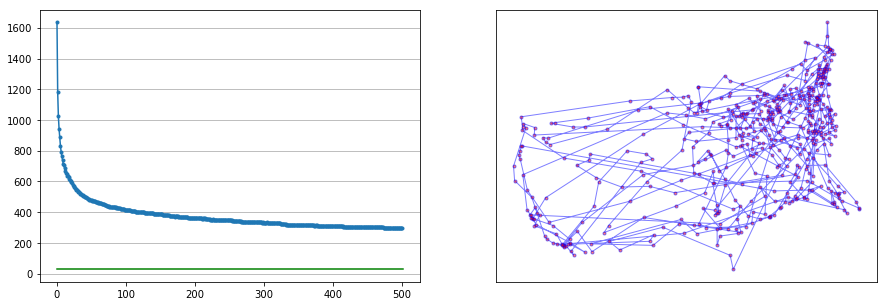

In [51]:
evaluate_tsp(myfancyalgorithm, coordinates, epochs=500)

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.